In [1]:
# Copyright 2020 Bimghi Choi. All Rights Reserved.
# 예측 + 투자전략 시스템

# _*_ coding: utf-8 _*_

from tensorflow import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]='0, 1'

In [2]:
import util
import preprocess as prepro
import models
import learn
from learn import GenerateResult
import math
import datetime

In [3]:
#tf.keras.backend.set_floatx('float64')

In [4]:
import gc
gc.collect()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
#    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')    
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')    
    #tf.config.experimental.set_virtual_device_configuration(
    #    gpus[1],
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가장 장치가 설정되어야만 합니다
    print(e)

In [5]:
file_name = '~/Data/kospi200f_809_0515.csv'
item_name = 'kospi200f_reinfo_809'
train_start = '2000-01-31'
train_end = '2019-01-02'
test_start = '2019-01-02'
test_end = '2020-05-15'

remove_columns = ['date', '종가', '시가', '고가', '저가']
target_column = '종가'
input_columns = []
target_type = 'rate'

model_name = 'ddaeryuble5-1'
channel = False

trans_day = 1

target_alpha = 100
future_day = 5
train_end_back = -2
n_timestep = 50
time_interval = 2
input_size = 809
n_unit = 800
batch_size = 10
learning_rate = 0.0005
epochs = 399

alpha = 0.5

comment = "2일 예측, model1 먼저 학습후 model2 5배의 iteration으로 학습"

checkpoint_path = model_name + "/pred"+str(future_day)+"_trans"+str(trans_day)+".ckpt"

In [6]:
dataframe = util.read_datafile(file_name)
df = dataframe.copy()
#df = prepro.target_conversion(df, target_column, future_day, type=target_type)
for i in range(len(df[target_column]) -future_day):
    df.loc[i, target_column] = ((df.loc[i + future_day, target_column] - df.loc[i, target_column]) 
                                / df.loc[i, target_column]) * target_alpha 

In [7]:
df.head(20)

,date,시가지수(포인트),고가지수(포인트),저가지수(포인트),종가지수(포인트),수익률(%),수익률 (1주)(%),수익률 (1개월)(%),수익률 (3개월)(%),수익률 (6개월)(%),...,"주요상품선물_천연가스(선물, NYMEX)($/mmBtu)",주요상품선물_금(선물)($/ounce),주요상품선물_은(선물)($/ounce),주요상품선물_알루미늄(선물)($/ton),주요상품선물_옥수수(최근월물)(￠/bu),대두박(￠/bu),종가,시가,고가,저가
0,2000-01-31,-0.218225,-0.493106,-0.400439,-0.223565,0.212872,1.352924,-0.851790,-0.382658,-0.162615,...,1.653438,-0.853010,0.974513,0.827681,0.373581,0.614542,-0.961538,116.85,120.10,116.65
1,2000-02-01,-0.213200,-0.230417,-0.373954,-0.595373,-0.407635,1.808646,-1.074203,-1.707405,-0.490731,...,1.687061,-0.039689,0.193571,1.002058,0.594935,0.706918,3.381014,120.85,121.70,115.35
2,2000-02-02,-0.208520,-0.448886,-0.367787,-0.200398,0.696677,2.107257,-0.769928,-1.558400,0.074389,...,1.809524,0.800355,0.031266,0.069626,0.430159,0.725768,3.292528,116.55,119.70,115.95
3,2000-02-03,-0.204125,-0.216603,-0.062403,-0.021445,0.366314,1.488978,-0.625155,-1.268930,-0.079967,...,1.213642,1.515992,0.623370,0.378121,0.084769,0.352875,1.677149,119.35,120.25,116.80
4,2000-02-07,-0.200000,0.378008,0.426748,0.592789,0.949260,1.101574,1.281908,-1.288431,1.273730,...,0.689954,3.856851,0.568635,-0.322023,0.518339,0.702038,0.653862,120.40,123.45,119.75
5,2000-02-08,-0.196110,0.353748,0.677387,0.254527,-0.366454,1.138729,0.998930,-1.329397,0.942469,...,0.332052,2.657684,1.222974,-0.720402,0.474125,0.440887,1.319588,122.90,123.60,120.95
6,2000-02-09,-0.192447,0.306497,0.819824,0.658684,0.641075,1.076862,1.233568,-1.637689,0.994675,...,0.557674,3.026664,2.114708,-0.407511,0.622228,0.721716,-1.867641,122.40,124.10,121.85
7,2000-02-10,0.330923,0.617187,0.552762,0.366383,-0.311193,0.651653,0.275024,-1.607973,0.269679,...,0.812787,3.316674,1.871659,-0.157431,0.985272,1.379493,-5.575906,120.85,125.05,120.40
8,2000-02-11,0.977388,0.576306,0.048738,-0.013448,-0.428351,0.326747,0.131530,-1.828185,0.546650,...,0.675096,2.384344,0.988933,-0.154629,0.473525,0.907189,-8.274721,123.60,124.75,119.85
9,2000-02-14,-0.649462,-0.806483,-0.954529,-1.222378,-1.533955,-1.217328,-0.075927,-2.486079,0.140712,...,0.504701,1.935983,0.085505,-0.246361,0.529501,0.923675,-1.422414,118.85,119.00,115.25


In [8]:
"""
def loss_fn_(m, train_x, train_y):
    
    #preds = m(train_x)[:, n_timestep-1, :-1].reshape((-1))
    targets = train_y[:, n_timestep-1, 1:].reshape((-1))
    base_prices = train_x[:, n_timestep-1, :-1].reshape((-1))
    rates = (tagets - bse_prices) / base_prices
    updown = np.sign(targets - base_prices)
    preds = model(train_x)
    
    
    returns = [1.0]
    avg_return = 1.0
    avg_std = 0.0
    state = np.zeros((4))
    state[0] = 1.0 # average return
    state[1] = 0.0 # standard dev. of returns
    state[2] = 1.0
    state[3] = preds[train_x[0]]
    
    model2 = layers.Dense(units=10, activaton='tanh')
    
    #investment rate
    inv_r = np.zeros((len(train_y)))
    best_inv = np.zeros((len(train_y)))
    
    for i in range(len(targets)):
        state[0] = 
        state[1] = 
        state[2] = (len(train_y) - i) / len(train_y) 
        inv_r[i] = model2(state)
        returns.append(rates[i]*inv_r[i] + 1-abs(inv_r[i]))
        
        r = tf.random.normal([100], mean=inv_r[i])
        sharp_ratio = np.zeros((len(r)))
        returns_random = [1.0]

        for j in range(len(r)):  
            returns_random.append(rates[i]*r[j] + 1-abs(r[j]))
            for k in range(i+1, len(train_y)):
                state[0] =
                state[1] = 
                state[2] = (len(train_y) - k) / len(train_y)
                inv_r[k] = model2(state, training=False)
                returns_random.append(rates[k]*inv_r[k] + 1-abs(inv_r[k]))
            avg_return = tf.math.reduce_prod(returns_random)**(1/(len(r)-i))
            std_return = tf.math.reduce_std(returns_random)
            sharp_ratio[j] = avg_return / std_return
        best_return_index = tf.math.argmax(sharp_ratio)
        best_inv[i] = r[best_return_index]

    return tf.math.square(inv_r - best_inv)
"""

"\ndef loss_fn_(m, train_x, train_y):\n    \n    #preds = m(train_x)[:, n_timestep-1, :-1].reshape((-1))\n    targets = train_y[:, n_timestep-1, 1:].reshape((-1))\n    base_prices = train_x[:, n_timestep-1, :-1].reshape((-1))\n    rates = (tagets - bse_prices) / base_prices\n    updown = np.sign(targets - base_prices)\n    preds = model(train_x)\n    \n    \n    returns = [1.0]\n    avg_return = 1.0\n    avg_std = 0.0\n    state = np.zeros((4))\n    state[0] = 1.0 # average return\n    state[1] = 0.0 # standard dev. of returns\n    state[2] = 1.0\n    state[3] = preds[train_x[0]]\n    \n    model2 = layers.Dense(units=10, activaton='tanh')\n    \n    #investment rate\n    inv_r = np.zeros((len(train_y)))\n    best_inv = np.zeros((len(train_y)))\n    \n    for i in range(len(targets)):\n        state[0] = \n        state[1] = \n        state[2] = (len(train_y) - i) / len(train_y) \n        inv_r[i] = model2(state)\n        returns.append(rates[i]*inv_r[i] + 1-abs(inv_r[i]))\n        \n 

In [9]:
def make_remaining_days(n_batches, n_steps):
    remaining_days = []
    for i in range(n_batches):
        temp = []    
        for j in range(n_steps):
            temp.append((n_batches - i) / n_batches)
        remaining_days.append(np.array(temp))
    return np.array(remaining_days)

In [10]:
#@tf.function
def loss_fn_model1(m1, train_x, train_y):
    
    rates = train_y / 100
    updown = tf.math.sign(train_y)
    preds = tf.cast(m1(train_x), dtype=tf.float64)
    profits = tf.cast(1 + tf.convert_to_tensor(rates, dtype=tf.float64)*np.sign(preds), dtype=tf.float64)
    
    loss1 = keras.losses.MSE(preds, train_y)
    
    batches = train_y.shape[0]

    return_plus = []
    return_minus = []
    for i in range(batches):
        if profits[i, -1, 0] - 1 > 0: return_plus.append(profits[i, -1, 0]-1)      
        else: return_minus.append(1-profits[i, -1, 0])    

    loss2 = tf.cast(tf.math.reduce_mean(return_plus), dtype=tf.float64) - tf.cast(tf.math.reduce_mean(return_minus), dtype=tf.float64) 
    
    return loss1 - loss2


In [11]:
#@tf.function
def loss_fn_model2(m1, m2, train_x, train_y):
    
    rates = train_y / 100
    updown = tf.math.sign(train_y)
    preds = tf.cast(tf.math.sign(m1(train_x)), dtype=tf.float64)
    profits = tf.cast(1 + tf.convert_to_tensor(rates, dtype=tf.float64)*preds, dtype=tf.float64)
    
    batches = train_y.shape[0]
    steps = train_y.shape[1]     

    n = - int(future_day/time_interval) # calc the number of unkown steps    
    
    # input = [preds, profits, the rate of remaining days]
    #train_x_m2 = np.zeros((batches, steps, 3))
    #train_x_m2[:, :, 0] = np.sign(preds[:, :, 0])
    #train_x_m2[:, :, 1] = profits[:, :, 0]
    #train_x_m2[:, :, 2] = make_remaining_days(batches, steps)
    
    # unknown future profits are relaced by average profits
    #for i in range(len(train_x_m2)):
    #    train_x_m2[i, n:, 1] = tf.math.reduce_mean(train_x_m2[i, :n, 1])

    train_x_m2 = tf.concat([preds, rates], 2)
    #train_x_m2 = tf.concat([train_x_m2, make_remaining_days(batches, steps).reshape((batches, steps, 1))], 2)    

    # model2의 output이 목표일까지의 남은 일수의 기하평균 수익률이 되도록 학습
    targets = np.zeros(len(profits))
    
    targets[:-1] = tf.reshape(profits[1:, -1, 0], [-1]) 
    
    loss = keras.losses.MSE(tf.reshape(m2(train_x_m2)[:, -1, 0], [-1]), targets)

  
    return loss


In [12]:
#@tf.function
def test(m1, m2, test_x, test_y):    
    rates = test_y / 100
    n = - int(future_day/time_interval)
    for i in range(len(rates)):
        rates[i, n:, 0] = 0#tf.math.reduce_mean(rates[i, :n, 0])
    preds = tf.cast(tf.math.sign(m1.predict(test_x)), dtype=tf.float64)
    #rates = tf.cast(tf.random.normal((), mean=test_y, stddev=1) / 100, dtype=tf.float64)
    profits = 1 + tf.convert_to_tensor(rates, dtype=tf.float64)*preds
    
    batches = test_y.shape[0]
    steps = test_y.shape[1]     

    test_x_m2 = np.concatenate((preds, rates), axis=2).reshape((-1, n_timestep, 2))
    
    avg_return = tf.math.reduce_prod(tf.reshape(m2(test_x_m2)[:, -1, 0], [-1]))**(1/batches)
    
    for k in range(10000):
        new_test_x_m2 = test_x_m2.copy()
        for i in range(batches):
            new_test_x_m2[i, :, 0] = max(-1, min(1, tf.cast(tf.random.normal((), mean=test_x_m2[i, -1, 0], stddev=1), dtype=tf.float64)))

        new_avg_return = tf.math.reduce_prod(tf.reshape(m2(new_test_x_m2)[:, -1, 0], [-1]))**(1/batches)
        if new_avg_return > avg_return:
            test_x_m2 = new_test_x_m2.copy()
            avg_return = new_avg_return
        
    return np.array(test_x_m2[:, -1, 0]).reshape(-1)

In [13]:
#@tf.function
def gradient1(model1, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model1(model1, input_data, output_data)
    return tape.gradient(loss, model1.trainable_variables)
#@tf.function
def gradient2(model1, model2, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model2(model1, model2, input_data, output_data)
    return tape.gradient(loss, model2.trainable_variables)

In [14]:

#strategy = tf.distribute.MirroredStrategy()
#with strategy.scope():
model1 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
model2 = models.LSTM(n_timestep,2,10,regularizers_alpha=0.01,drop_rate=0.5)

    #cp_callback = tf.keras.callbacks.ModelCheckpoint(
    #    checkpoint_path, verbose=1, save_weights_only=True,
        # 다섯 번째 에포크마다 가중치를 저장합니다
    #    save_freq=5)

#    model.compile(optimizer='adam',
#                  loss='mse')
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])
            
#    model2 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
#    model2.compile(optimizer='adam',
#                  loss='mse')
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])            

#modle_name = model_name + "tanh"            
#model.save_weights(checkpoint_path)
#model2.save_weights("modle2_"+ checkpoint_path)

In [15]:
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []
test_target = []

# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)
early_stopping = learn.EarlyStopping(patience=2, verbose=1)

while True:

    gc.collect()
    
    train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                           current_train_start, current_train_end,
                                                           current_test_start, current_test_end,
                                                           future_day, n_timestep, time_interval)
    
    # input_size, columns reset
    input_size = len(df.columns) - len(remove_columns)
    input_columns = df.columns.copy()

    train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
    test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

    #model.compile(optimizer='adam',
    #          loss=loss_fn)
    #          #callbacks=[cp-callback]
    #          #metrics=['accuracy'])
    
    # the firs training dataset
    train_x = train_x[:train_end_back]
    train_y = train_y[:train_end_back]    
    
    #global_step = tf.train.get_or_create_global_step()
    global_step = tf.Variable(0, trainable=False)
    #lr_decay = tf.train.exponential_decay(learning_rate, global_step,
    #                                      train_input.shape[0]/batch_size*5, 0.5, staircase=True)
    lr_decay = tf.compat.v1.train.exponential_decay(learning_rate,global_step, int(len(train_y)/batch_size), 0.96, staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    #optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    updown = np.sign(test_y[:, -1, 0]).reshape((-1))    
    iter = epochs
    basic_epochs = tf.cast(epochs / 5, dtype=tf.int32)
    
    # model1 training
    for iteration in range(iter):
        batch_input, batch_output = learn.next_random_interval_batch(train_x, train_y, batch_size, future_day)
        
        gradients1 = gradient1(model1, batch_input, batch_output)
        optimizer.apply_gradients(zip(gradients1, model1.trainable_variables))
        if iteration % 100 == 0:
            #test_MSE = model.evaluate(test_x, test_y)
            prediction = model1.predict(test_x)
            prediction_MSE = sum((updown - prediction[:, -1, 0]).reshape(-1)**2)/len(test_y)
            print('prediction_MSE =', prediction_MSE)

        if iteration > epochs / 2 and early_stopping.validate(prediction_MSE)==True:
            break
            
    # model2 training
    elarly_stopping = learn.EarlyStopping(patience=2, verbose=1)
    iter = 5*iter
    for iteration in range(iter):
        batch_input, batch_output = learn.next_random_interval_batch(train_x, train_y, batch_size, future_day)
        
        gradients2 = gradient2(model1, model2, batch_input, batch_output)
        optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))
        if iteration % 100 == 0:
            rates = test_y / 100
            preds = tf.cast(tf.math.sign(model1(test_x)), dtype=tf.float64)
            profits = tf.cast(1 + tf.convert_to_tensor(rates, dtype=tf.float64)*preds, dtype=tf.float64)

            test_x_m2 = tf.concat([preds, rates], 2)

            # model2의 output이 목표일까지의 남은 일수의 기하평균 수익률이 되도록 학습
            targets = np.zeros(len(profits))

            targets[:-1] = tf.reshape(profits[1:, -1, 0], [-1]) 

            MSE = keras.losses.MSE(tf.reshape(model2(test_x_m2)[:, -1, 0], [-1]), targets)          
           
            print('prediction_MSE =', MSE)

        if iteration > iter / 2 and early_stopping.validate(MSE)==True:
            break    
    
    if iter > basic_epochs: iter -= basic_epochs
    if iter < basic_epochs: iter = basic_epochs

    print('test dates ' + current_test_start + "~" + current_test_end)
    
    # prediction1 accuracy
    prediction1 = model1.predict(test_x)[:, -1, 0].reshape(-1)
    temp = tf.math.multiply(updown, prediction1)
    accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
    print('prediction1 accuracy = ', accu)

    # reinforced prediction2
    prediction2 = test(model1, model2, test_x, test_y)    
    temp = tf.math.multiply(updown, prediction2)
    accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
    print('prediction2 accuracy = ', accu)
    
    test_prediction1.append(prediction1)
    test_prediction2.append(prediction2)
    
    # escape from while
    if current_test_end == test_end:
     break

    #train, start dates shift
    current_train_end = df.loc[prepro.date_to_index(df, current_train_end) + trans_day, 'date']
    current_train_start = df.loc[prepro.date_to_index(df, current_train_end) - 500, 'date']
    current_test_start = df.loc[prepro.date_to_index(df, current_test_start) + trans_day, 'date']
    if prepro.date_to_index(df, test_end) - prepro.date_to_index(df, current_test_start) < trans_day:
        current_test_end = test_end
    else:
        current_test_end = df.loc[prepro.date_to_index(df, current_test_end) + trans_day, 'date']


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

prediction_MSE = 1.081985742528062
prediction_MSE = 1.160334485114714
prediction_MSE = 0.8973480317891558
prediction_MSE = 2.793957373426
step :  1
step :  2
step :  3
Training process is stopped early....

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To chan

prediction_MSE = 0.9140294961297046
prediction_MSE = 0.8434624685708885
prediction_MSE = 0.7988667690838636
step :  11
Training process is stopped early....
prediction_MSE = tf.Tensor(0.8097311147712958, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8086424702856334, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8065957412681293, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8135383205279965, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.810253821227036, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8089718173510505, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8201737802715492, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8115532708829143, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8231101098402895, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8219775956923172, shape=(), dtype=float64)
step :  12
Training process is stopped early....
test dates 2019-01-10~2019-01-10
prediction1 accuracy =  tf.Tensor(1.0, sha

prediction_MSE = tf.Tensor(0.806676789743733, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8057287667503523, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8197211662811696, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8298697660762286, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8336414650987081, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8231553184667781, shape=(), dtype=float64)
step :  4
Training process is stopped early....
test dates 2019-01-21~2019-01-21
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 3.6761697447777273
prediction_MSE = 3.2005437290156493
prediction_MSE = 2.6139584328213914
step :  5
Training process is stopped early....
prediction_MSE = tf.Tensor(0.8225440256001662, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8213104532561744, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8234732199139785, shape=(), dty

prediction2 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 0.03776339866823264
prediction_MSE = 0.05368751546575368
prediction_MSE = 0.04407125669732537
step :  13
Training process is stopped early....
prediction_MSE = tf.Tensor(0.8109816209400869, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8035442419782299, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8146646851091788, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8102274243704102, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.794453237421763, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7912255583750181, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7820001827713128, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7870578418720839, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7923568544201807, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7883990017376306, shape=(), dtype=float64)
step :  14
Training process is stopped early....
test dat

prediction_MSE = tf.Tensor(0.8222857569273323, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8228163921632223, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8226740942017194, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8129899410092243, shape=(), dtype=float64)
step :  28
Training process is stopped early....
test dates 2019-02-14~2019-02-14
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 0.38178308061007105
prediction_MSE = 1.8775976852875909
prediction_MSE = 1.9068486646881553
step :  29
Training process is stopped early....
prediction_MSE = tf.Tensor(0.7944175365626194, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8065590191909564, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8108122261986104, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8141172167627566, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8144608018420207, shape=(),

prediction_MSE = tf.Tensor(0.8185189406572171, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8132946929236482, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8099397694340702, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8065811808109835, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8156532618706969, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7975143759545631, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8050642950379938, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8074842847946115, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8078455392990236, shape=(), dtype=float64)
step :  44
Training process is stopped early....
test dates 2019-02-26~2019-02-26
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 1.0515632896677238
prediction_MSE = 1.2068797577515957
prediction_MSE = 2.0771626373207255
step :  45
Training process is sto

step :  58
Training process is stopped early....
test dates 2019-03-08~2019-03-08
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 4.276315679934669
prediction_MSE = 3.410573920616944
prediction_MSE = 3.45037739180043
step :  59
Training process is stopped early....
prediction_MSE = tf.Tensor(0.8205702574450733, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8155506631061513, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8206449855497091, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.823920484251417, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8205450968691821, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8182992627649242, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8198183063819329, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8198081603689076, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8237036529926769, shape=(), dtype

prediction_MSE = tf.Tensor(0.8222213312139139, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8207467162704098, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8255729737318376, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8256591945698943, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8177670678742857, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8220103438629032, shape=(), dtype=float64)
step :  74
Training process is stopped early....
test dates 2019-03-20~2019-03-20
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 1.8507534111909116
prediction_MSE = 1.6989462895689975
prediction_MSE = 1.4669410777443057
step :  75
Training process is stopped early....
prediction_MSE = tf.Tensor(0.8249949987966296, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8189623764565113, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8188917163956866, shape=(), 

prediction_MSE = 2.295514832132884
prediction_MSE = 1.63369901900991
prediction_MSE = 0.4562844744732155
step :  89
Training process is stopped early....
prediction_MSE = tf.Tensor(0.8227674082693426, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8313724412701937, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8282139561277155, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8225745145740717, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8231183294982181, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8256379638954883, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8258432412930041, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8302198088899537, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8266708924635999, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8265077783659223, shape=(), dtype=float64)
step :  90
Training process is stopped early....
test dates 2019-04-01~2019-04-01
prediction1 accuracy =  tf.Tensor(1.0, shape

prediction_MSE = tf.Tensor(0.8175418859903836, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.81704269430114, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8204949928369842, shape=(), dtype=float64)
step :  104
Training process is stopped early....
test dates 2019-04-10~2019-04-10
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 0.10694768727021042
prediction_MSE = 0.31621336152287327
prediction_MSE = 1.4704736580639557
step :  105
Training process is stopped early....
prediction_MSE = tf.Tensor(0.8249942408586008, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8283910178711587, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.826211829697602, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8319580821027017, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8317176911107573, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8304775822844022, shape=(),

prediction_MSE = tf.Tensor(0.8187918266101271, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8250613738628232, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8239853011301115, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8173900216076078, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8256959156153734, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8196146425874851, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8208526654746038, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8159880177118453, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8243706841515319, shape=(), dtype=float64)
step :  120
Training process is stopped early....
test dates 2019-04-22~2019-04-22
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 0.17807850900686617
prediction_MSE = 0.43926395847064725
prediction_MSE = 0.35677910159680337
step :  121
Training process i

prediction_MSE = tf.Tensor(0.8248308592023115, shape=(), dtype=float64)
step :  134
Training process is stopped early....
test dates 2019-05-02~2019-05-02
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 4.822281879770131
prediction_MSE = 4.0262618555345995
prediction_MSE = 3.675890444842711
step :  135
Training process is stopped early....
prediction_MSE = tf.Tensor(0.8180882401483736, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8182837343684355, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8201928893100927, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8219433351031888, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8279419992479831, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8237361109458021, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8228669995716622, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8251685757741711, shape=(), 

prediction_MSE = tf.Tensor(0.8229711389425489, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8274945120797952, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8256484708788072, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8269350522119225, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8261762890794309, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8196929967284952, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8312522294041322, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8295555181081369, shape=(), dtype=float64)
step :  150
Training process is stopped early....
test dates 2019-05-15~2019-05-15
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 0.03611664859035102
prediction_MSE = 0.0012250727664309125
prediction_MSE = 0.26923801080076615
step :  151
Training process is stopped early....
prediction_MSE = tf.Tensor(0.8195472998723154, sha

step :  164
Training process is stopped early....
test dates 2019-05-24~2019-05-24
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 0.28416193880508445
prediction_MSE = 0.8126090679915778
prediction_MSE = 1.002736238326306
step :  165
Training process is stopped early....
prediction_MSE = tf.Tensor(0.826542892599619, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8284830280132702, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8184131421745064, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8259363015627628, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8295863539069757, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8267873039923792, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8228115261482714, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8244297820170345, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8299200469296331, shape=(),

prediction_MSE = tf.Tensor(0.8160723366194453, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8180584813557381, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8104057724700056, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8235705820707153, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8206388300714593, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8112026765516589, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.819773081552345, shape=(), dtype=float64)
step :  180
Training process is stopped early....
test dates 2019-06-05~2019-06-05
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 1.9315280030230184
prediction_MSE = 1.033760492482315
prediction_MSE = 0.973169129607323
step :  181
Training process is stopped early....
prediction_MSE = tf.Tensor(0.8268386837543495, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8257315542249586, shape=(), d

prediction2 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 0.4961606807880239
prediction_MSE = 0.6459926136515728
prediction_MSE = 0.48628537783504644
step :  195
Training process is stopped early....
prediction_MSE = tf.Tensor(0.8046416407233323, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8291639316092905, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8166379135326594, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8213169353584959, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8172657598287891, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8199946843417507, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8275103445104293, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8112539992583976, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8025523535582444, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7911499553089563, shape=(), dtype=float64)
step :  196
Training process is stopped early....
test da

prediction_MSE = tf.Tensor(0.8131879426331103, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.807107046512229, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.808053200779014, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.805179817042756, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7999453902705369, shape=(), dtype=float64)
step :  210
Training process is stopped early....
test dates 2019-06-27~2019-06-27
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 0.9261226700296338
prediction_MSE = 0.8131380906049748
prediction_MSE = 0.6630459297463711
step :  211
Training process is stopped early....
prediction_MSE = tf.Tensor(0.786263059374992, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7690164668679387, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7511251757538417, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7600201801872117, shape=(), dt

prediction_MSE = 2.081847150655073
prediction_MSE = 1.722389648739636
step :  225
Training process is stopped early....
prediction_MSE = tf.Tensor(0.7927191672090181, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8086937119408191, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8158010886455145, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8021802196744829, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.796184521935718, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8101615414091157, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8137410129490128, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8118921254208544, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8015668410287304, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8037371357760357, shape=(), dtype=float64)
step :  226
Training process is stopped early....
test dates 2019-07-09~2019-07-09
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 ac

prediction_MSE = tf.Tensor(0.805062155819769, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8082096610053355, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8025691203012144, shape=(), dtype=float64)
step :  240
Training process is stopped early....
test dates 2019-07-18~2019-07-18
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 0.007818481778386399
prediction_MSE = 0.008538049052052799
prediction_MSE = 0.0066415980632541505
step :  241
Training process is stopped early....
prediction_MSE = tf.Tensor(0.7931457921151832, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7852608761589899, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7929341106728458, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8005752142198617, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8108163052050124, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7780140559756923, sh

prediction_MSE = tf.Tensor(0.8108928421485331, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7713978219655928, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8015907483670759, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7950793015600119, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8050768095215552, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7952856347213952, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7986119121194548, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7980243925294559, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8172396800650326, shape=(), dtype=float64)
step :  256
Training process is stopped early....
test dates 2019-07-30~2019-07-30
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 3.4735017823149974
prediction_MSE = 3.3047125244195286
prediction_MSE = 4.071845317961561
step :  257
Training process is st

step :  270
Training process is stopped early....
test dates 2019-08-08~2019-08-08
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 3.730639820713666
prediction_MSE = 5.401541185691272
prediction_MSE = 5.736756970009139
step :  271
Training process is stopped early....
prediction_MSE = tf.Tensor(0.7657367180805785, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7685720317031297, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7734620128731109, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7851053858274817, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.77718843740033, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7870234708818522, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7397377153601816, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7764039070025319, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8026171788151828, shape=(), dty

prediction_MSE = tf.Tensor(0.7934770655012926, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7926562287867114, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7869270246033899, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7850574319975046, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7927412440097648, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7742877482087351, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8016447546490326, shape=(), dtype=float64)
step :  286
Training process is stopped early....
test dates 2019-08-21~2019-08-21
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 1.0621743619310244
prediction_MSE = 1.1561809558600977
prediction_MSE = 2.258276669083955
step :  287
Training process is stopped early....
prediction_MSE = tf.Tensor(0.8396830253909151, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8273983278968764, shape=(),

prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 0.4980495203268811
prediction_MSE = 0.5720475989661209
prediction_MSE = 0.8566565094996728
step :  301
Training process is stopped early....
prediction_MSE = tf.Tensor(0.8084579923321122, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7974643413575819, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8129156697454079, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8023630189936739, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7737300087166119, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8081562913631046, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7930878263838537, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8062284510756967, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7765430909970839, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8014924530645864, shape=(), dtype=float64)
step :  302
Training process is stopped early....
test dat

prediction_MSE = tf.Tensor(0.7831190644801609, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.797574526005068, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8019829222869248, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7951344699379206, shape=(), dtype=float64)
step :  316
Training process is stopped early....
test dates 2019-09-11~2019-09-11
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 0.9995028994505271
prediction_MSE = 0.3322521935120939
prediction_MSE = 0.28509903907967615
step :  317
Training process is stopped early....
prediction_MSE = tf.Tensor(0.750014013548256, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7975218280501082, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7846410135226165, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7835197784689996, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.781196368656456, shape=(), 

prediction_MSE = tf.Tensor(0.7993675055367966, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.42257714862115847, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.5866298600706301, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.5451341031702306, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7298650890001035, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.26493209981039456, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7209019709411137, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.496372180364407, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.2928110400549855, shape=(), dtype=float64)
step :  332
Training process is stopped early....
test dates 2019-09-25~2019-09-25
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 2.5776009122143115
prediction_MSE = 0.3490440615821946
prediction_MSE = 3.1266102153861084
step :  333
Training process is 

step :  346
Training process is stopped early....
test dates 2019-10-07~2019-10-07
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 2.6699840604508474
prediction_MSE = 2.5234652579658956
prediction_MSE = 4.834586570851172
step :  347
Training process is stopped early....
prediction_MSE = tf.Tensor(0.823923838651698, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8244921293140237, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8243005487742181, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.818314791308751, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8364202481755321, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8205585949842522, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8229362088033589, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8205656140479647, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8191411438390936, shape=(), d

prediction_MSE = tf.Tensor(0.7835844636085518, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7892748204515243, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7757377823829223, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.763863624073565, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7666263723213298, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7748655213709164, shape=(), dtype=float64)
step :  362
Training process is stopped early....
test dates 2019-10-18~2019-10-18
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 2.8479085173445498
prediction_MSE = 2.4273529439918526
prediction_MSE = 2.3895198463615976
step :  363
Training process is stopped early....
prediction_MSE = tf.Tensor(0.7554769183659715, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.732290149881468, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7393189415015513, shape=(), 

prediction_MSE = 0.005885665634707493
prediction_MSE = 0.5724990417196827
prediction_MSE = 0.6685137370077463
step :  377
Training process is stopped early....
prediction_MSE = tf.Tensor(0.7909521108054243, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7547470267014091, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7732932286785967, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7623313699060787, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7670732724540272, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.776157713191651, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7635543209957554, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7310368558410687, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7685874990664985, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7222182751206994, shape=(), dtype=float64)
step :  378
Training process is stopped early....
test dates 2019-10-30~2019-10-30
prediction1 accuracy =  tf.Tensor(1.0,

prediction_MSE = tf.Tensor(0.5627229136494272, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.6108296108146192, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7773520756163634, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.735853165577339, shape=(), dtype=float64)
step :  392
Training process is stopped early....
test dates 2019-11-08~2019-11-08
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 3.4846316193178986
prediction_MSE = 4.0386202616701325
prediction_MSE = 3.5307980521825044
step :  393
Training process is stopped early....
prediction_MSE = tf.Tensor(0.6350502340982445, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.6909411075789116, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7317080825274047, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.6167707292200397, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.6076502766012801, shape=(),

prediction_MSE = tf.Tensor(0.8057478137732268, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7984250668201298, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7591124531637128, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7766280781505799, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7533708684523077, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.6784594181949757, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7234707836705958, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.5576200689352504, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7398793154212768, shape=(), dtype=float64)
step :  408
Training process is stopped early....
test dates 2019-11-20~2019-11-20
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 1.3898752409550605
prediction_MSE = 2.0667436782172253
prediction_MSE = 2.4596354004104093
step :  409
Training process is s

step :  422
Training process is stopped early....
test dates 2019-11-29~2019-11-29
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 2.0921027511656263
prediction_MSE = 0.5630051956906412
prediction_MSE = 0.49114328238010785
step :  423
Training process is stopped early....
prediction_MSE = tf.Tensor(0.5887567139635088, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7754947385831343, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7675333575076024, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7859585538063243, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.750266144952608, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.546856262568113, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.6041040222833693, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.45288091526916574, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.352154263116077, shape=(),

prediction_MSE = tf.Tensor(0.4491755370347619, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.4995456588249567, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.4241241620276561, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.6299109313968678, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.6156251567979929, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.4271354311047304, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.47877924467924515, shape=(), dtype=float64)
step :  438
Training process is stopped early....
test dates 2019-12-11~2019-12-11
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 0.8415617686631196
prediction_MSE = 0.7359072876640893
prediction_MSE = 0.7198545153865945
step :  439
Training process is stopped early....
prediction_MSE = tf.Tensor(0.4324873646371685, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7568631909554178, shape=(

prediction2 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 4.219892134267923
prediction_MSE = 1.1009814021394342
prediction_MSE = 1.0619891749787078
step :  453
Training process is stopped early....
prediction_MSE = tf.Tensor(0.3848141598815005, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7463004605606329, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.40202856304896173, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.4918097701070714, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.27022334085985733, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.209041424088813, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.5484392588872566, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.30724328119555366, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.37067408377096456, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.34065858574854246, shape=(), dtype=float64)
step :  454
Training process is stopped early....
test 

prediction_MSE = tf.Tensor(0.7627517171118257, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7925580583273053, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8175260414247987, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8050717823241627, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8030149449407418, shape=(), dtype=float64)
step :  468
Training process is stopped early....
test dates 2020-01-06~2020-01-06
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 0.6396738324990283
prediction_MSE = 0.4022479043188989
prediction_MSE = 0.5513274154071865
step :  469
Training process is stopped early....
prediction_MSE = tf.Tensor(0.7935302668073838, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8112937271544638, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7379821197284855, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7992800042143813, shape=()

prediction_MSE = 0.3819915604912163
prediction_MSE = 0.6312348329219555
step :  483
Training process is stopped early....
prediction_MSE = tf.Tensor(0.6150669805107469, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.6798597556795016, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7911619370406839, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.6695985162337479, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.6327270034676644, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.608355231250389, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.6539858009355157, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.6102476313254215, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.6964267843660679, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.6893301477294358, shape=(), dtype=float64)
step :  484
Training process is stopped early....
test dates 2020-01-16~2020-01-16
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction2 

prediction_MSE = tf.Tensor(0.6624896694921887, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.705942562090641, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7349972940801308, shape=(), dtype=float64)
step :  498
Training process is stopped early....
test dates 2020-01-29~2020-01-29
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 3.875115285981238
prediction_MSE = 3.4323844135775836
prediction_MSE = 3.5767932494104713
step :  499
Training process is stopped early....
prediction_MSE = tf.Tensor(0.4323870229061555, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7350650545653856, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.811354287224276, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8026342666335609, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.719030492845377, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.5941605653032553, shape=(), dt

prediction_MSE = tf.Tensor(0.7360214951211361, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.778552194789782, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8089600231670744, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7841097466908309, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8035074825733233, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8063168671266254, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7666491265277422, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.6743034822213758, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7617163603581503, shape=(), dtype=float64)
step :  514
Training process is stopped early....
test dates 2020-02-10~2020-02-10
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 0.6385030307337145
prediction_MSE = 0.06210942682004372
prediction_MSE = 0.04008143273796705
step :  515
Training process is 

prediction_MSE = tf.Tensor(0.8251763725484693, shape=(), dtype=float64)
step :  528
Training process is stopped early....
test dates 2020-02-19~2020-02-19
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 4.373667367326561
prediction_MSE = 2.542860244084327
prediction_MSE = 2.0145176167239356
step :  529
Training process is stopped early....
prediction_MSE = tf.Tensor(0.8250729599963655, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8246324193515306, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8272824154928458, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8333678567229441, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8277725776135867, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.840224379487168, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.83155668880012, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8323587021858572, shape=(), dty

prediction_MSE = tf.Tensor(0.8166486862757125, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.820765615984115, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8212004774855473, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8244977580054638, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8218474740942838, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.822700152406469, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8239609539234607, shape=(), dtype=float64)
step :  544
Training process is stopped early....
test dates 2020-03-02~2020-03-02
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 1.1607109359800951
prediction_MSE = 0.9631562844368418
prediction_MSE = 0.9785692222328093
step :  545
Training process is stopped early....
prediction_MSE = tf.Tensor(0.832151855345785, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8295197970717574, shape=(), d

prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 6.0113506589189
prediction_MSE = 4.4459557555146745
prediction_MSE = 5.761647380345551
step :  559
Training process is stopped early....
prediction_MSE = tf.Tensor(0.83286994814911, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8155935104937839, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8224345078119235, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8251282930270918, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8309016429956309, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8316558322011502, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8246435694574963, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8250059347983694, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.826491630403897, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8241758710259006, shape=(), dtype=float64)
step :  560
Training process is stopped early....
test dates 2020

prediction_MSE = tf.Tensor(0.8093621461153475, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8035400744452978, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.7947556643721896, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8049494230409806, shape=(), dtype=float64)
step :  574
Training process is stopped early....
test dates 2020-03-23~2020-03-23
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 42.323904379833266
prediction_MSE = 51.923011568133234
prediction_MSE = 42.38107770758893
step :  575
Training process is stopped early....
prediction_MSE = tf.Tensor(0.7979811572436688, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.798019067923633, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8076342620284436, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8052493481702783, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8055769336470462, shape=(), 

prediction_MSE = tf.Tensor(0.8282884890036826, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8316832281303874, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8257591773845583, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8309421750892056, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8285483496351311, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8252140574768418, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8381503726225361, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8339477769044521, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8347781712800497, shape=(), dtype=float64)
step :  590
Training process is stopped early....
test dates 2020-04-02~2020-04-02
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 0.09099767755396115
prediction_MSE = 0.04538977248538245
prediction_MSE = 0.003683411833264927
step :  591
Training process 

prediction_MSE = tf.Tensor(0.8094946004785051, shape=(), dtype=float64)
step :  604
Training process is stopped early....
test dates 2020-04-13~2020-04-13
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 7.396163653215027
prediction_MSE = 5.636485382743558
prediction_MSE = 4.904816285798589
step :  605
Training process is stopped early....
prediction_MSE = tf.Tensor(0.8141942320363036, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8177390397177078, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8065461720144071, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8111467387978202, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.807440044170793, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8058380226753457, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8140598879256231, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8136007922642854, shape=(), dt

prediction_MSE = tf.Tensor(0.8275550231451376, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.833304412985175, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8374352428802467, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8224878062788434, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8249896932377396, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8133996224938187, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.81063286740482, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8158028113962814, shape=(), dtype=float64)
step :  620
Training process is stopped early....
test dates 2020-04-24~2020-04-24
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 0.284062941658604
prediction_MSE = 0.07002541952374486
prediction_MSE = 0.13222222304717945
step :  621
Training process is stopped early....
prediction_MSE = tf.Tensor(0.8063354929177535, shape=(), 

step :  6
Training process is stopped early....
test dates 2020-05-08~2020-05-08
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction2 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 0.813621571906076
prediction_MSE = 1.0463388831457272
prediction_MSE = 0.5763858041314853
step :  7
Training process is stopped early....
prediction_MSE = tf.Tensor(0.811649603630272, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8178878100398492, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8210260221904129, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8174361506736574, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8237467140157264, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8216918604603052, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.820086227015068, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8263932287833065, shape=(), dtype=float64)
prediction_MSE = tf.Tensor(0.8330526206620767, shape=(), dtype

In [16]:
t1 = np.concatenate(test_prediction1)
t2 = np.concatenate(test_prediction2)

In [17]:
#t2

In [18]:
#test_prediction = np.concatenate(test_prediction, axis=0).reshape((-1, n_timestep, 1))
#train_prediction = learn.predict_batch_test(model1, train_x[:batch_size], len(train_x[:batch_size]))

# 원 지수, 날짜는 target conversion이 되기 전 dataframe에서 가져옴
test_dates, test_base_prices, train_dates, train_base_prices = prepro.get_test_dates_prices(dataframe, test_start, test_end,
                                                      train_start, train_end, n_timestep, time_interval, future_day, target_column)

# 전체 test_oouput 생성
_, test_data = prepro.get_train_test_data(df, target_column, remove_columns,
                                                   train_start, train_end,
                                                   test_start, test_end,
                                                   future_day, n_timestep, time_interval)
_, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

In [19]:
updown = np.sign(test_y[:, -1, 0]).reshape((-1))
#calculate accuracy
temp = tf.math.multiply(updown, t1.reshape((-1)))
accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
print('accuracy = ', accu)

accuracy =  tf.Tensor(0.4807121661721068, shape=(), dtype=float64)


In [20]:
updown.shape

(337,)

In [21]:
#train_base_prices = train_base_prices[:batch_size]
#train_prediction = train_prediction[:batch_size]
#train_y = train_y[:batch_size]

In [22]:
result = GenerateResult(t1, t2, test_y[:, -1, 0].reshape(-1), test_dates, n_timestep, future_day, trans_day)

In [23]:
#result.extract_last_output()
result.convert_price(test_base_prices,conversion_type=target_type)

info : ddaeryuble5-1_kospi200f_reinfo_809_100_1_2_0.49
MSE : 6.0789 , Accuracy : 0.49
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/ddaeryuble5-1_kospi200f_reinfo_809_100_1_2_0.49/assets


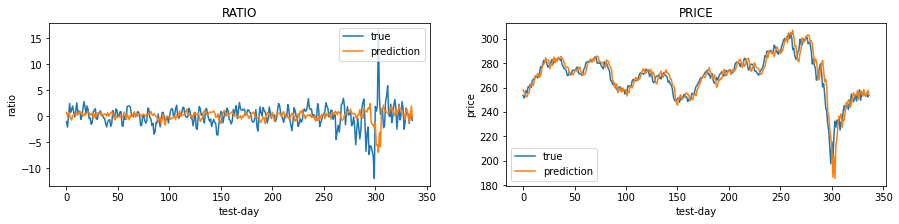

In [24]:
result.evaluation()
result.table()
result.save_result(model_name,item_name,n_unit,target_type,batch_size,n_timestep,time_interval,epochs,str(alpha),comment)
result.save_visualization()
result.save_model(model2)

In [25]:
"""
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []
test_target = []

# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)
early_stopping = learn.EarlyStopping(patience=2, verbose=1)


gc.collect()

train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                       current_train_start, current_train_end,
                                                       current_test_start, current_test_end,
                                                       future_day, n_timestep, time_interval)

# input_size, columns reset
input_size = len(df.columns) - len(remove_columns)
input_columns = df.columns.copy()

train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

#model.compile(optimizer='adam',
#          loss=loss_fn)
#          #callbacks=[cp-callback]
#          #metrics=['accuracy'])

# the firs training dataset
train_x = train_x[:-future_day]
train_y = train_y[:-future_day]    

#global_step = tf.train.get_or_create_global_step()
global_step = tf.Variable(0, trainable=False)
#lr_decay = tf.train.exponential_decay(learning_rate, global_step,
#                                      train_input.shape[0]/batch_size*5, 0.5, staircase=True)
lr_decay = tf.compat.v1.train.exponential_decay(learning_rate,global_step, int(len(train_y)/batch_size), 0.96, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

updown = np.sign(test_y[:, -1, 0]).reshape((-1))    
epochs = len(train_y)
for iteration in range(399):
    batch_input, batch_output = learn.next_random_interval_batch(train_x, train_y, batch_size, future_day)

    #noise = 2*np.random.randn(batch_size,n_timestep,1)
    #batch_output = batch_output+noise
    #batch_input = encoder(train_input[idx])
    gradients1 = gradient1(model1, model2, batch_input, batch_output)
    optimizer.apply_gradients(zip(gradients1, model1.trainable_variables))
    
    targets = tf.reshape(train_y[:, -1, 0], [-1])
    rates = targets / 100
    preds = tf.reshape(model1(train_x, training=False)[:, -1, 0], [-1])
    
    n = len(targets)    
    returns = [1.0]
    losses = []
    for i in range(n - 1):
       
        # average_return, std of returns, remaining days, preds[0] 
        state = []
        
        random_rates = []
        for k in range(i+1):
            random_rates.append(rates[k])
        # 실재 수익률을 기반으로 random 수익률 생성, 예측에 의한 porfits 생성 
        for k in range(i+1, n):
            random_rates.append(tf.random.normal((), mean=targets[k] / 100, stddev=0.1, dtype=tf.float64))
        profits = tf.convert_to_tensor(random_rates, dtype=tf.float64)*tf.cast(preds, dtype=tf.float64) + 1
        
        # 현재까지의 예측에 의한 수익률 기하평균 구하기
        returns_past = []
        for k in range(i+1):
            returns_past.append(profits[k])
        avg_return = tf.cast(tf.math.reduce_prod(returns_past)**(1/(i+1)), dtype=tf.float64)
        
        state.append(avg_return)
        state.append(tf.math.reduce_std(returns))
        state.append((n - i) / n)
        state.append(preds[i])
        state = np.array(state).reshape((1, 4))
     
        # 목표일까지의 기대 기하 평균 수익률 구하기 
        returns_future = []
        for j in range(i+1, n):
            returns_future.append(profits[j])
        avg_return_future = tf.math.reduce_prod(returns_future)**(1/(n-i-1))

        # 예측 기하 평균 수익률과 기대 기하 평균 수익률의 MSE
        value = tf.cast(model2(state, training=True)[0, 0], dtype=tf.float64)
        losses.append((value - avg_return_future)**2)
        if n == 3: break
    print("losses", losses)
    print("value", value)    
    with tf.GradientTape() as tape:
        gradients2 = tape.gradient(tf.math.reduce_sum(losses), model2.trainable_variables)
    optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))
    

    
    if iteration % 100 == 0:
        #test_MSE = model.evaluate(test_x, test_y)
        prediction = model1.predict(test_x)
        prediction_MSE = sum((updown - np.sign(prediction[:, -1, 0]).reshape(-1))**2)/len(test_y)
        print('prediction_MSE =', prediction_MSE)

    if iteration > epochs / 2 and early_stopping.validate(prediction_MSE)==True:
        break
epochs -= epochs / 5
if epochs <= 0: epochs = 100
"""

'\ncurrent_train_start = df.loc[prepro.date_to_index(df, train_start), \'date\']\ncurrent_train_end = df.loc[prepro.date_to_index(df, train_end), \'date\']\ncurrent_test_start = df.loc[prepro.date_to_index(df, test_start), \'date\']\ncurrent_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, \'date\']\n\n\n#  각 transfer 구간의 예측값들을 합치기 위하여\ntest_prediction1 = []\ntest_prediction2 = []\ntest_target = []\n\n# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)\nearly_stopping = learn.EarlyStopping(patience=2, verbose=1)\n\n\ngc.collect()\n\ntrain_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, \n                                                       current_train_start, current_train_end,\n                                                       current_test_start, current_test_end,\n                                                       future_day, n_timestep, time_interval)\n\n# input_size, columns reset\ninput_size 